In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
mpl.rcParams['figure.dpi'] = 300

In [5]:
def hyb_norm(RFU, somamers):
    # 1st normalization - Hybridization control normalization

    sel_HCE_seqid = list(somamers[somamers['Type'] == "Hybridization Control Elution"].index)
    n_HCE = len(sel_HCE_seqid)
    
    
    RFU_HCE_i = RFU.loc[:, sel_HCE_seqid]
    RFU_HCEref_i = RFU_HCE_i.median()
    # np.median(RFU_HCEref_i / RFU.loc[i, sel_HCE_seqid])
    
    # hyb_factor_per_well = (RFU_HCEref_i / RFU.loc[:, sel_HCE_seqid]).median(axis=1)
    hyb_factor_per_well = (RFU_HCEref_i / RFU_HCE_i).median(axis=1)
    RFU_hyb = RFU.mul(hyb_factor_per_well, axis=0)
    RFU_hyb = RFU_hyb.apply(lambda x: round(x, 1))
    
    return RFU_hyb

In [6]:
def msnCal_norm(RFU_hyb, somamers, sampl, dil_lab=("0", "0_005", "0_5", "20")):
    # 2nd normalization - Median signal normalization on calibrators
    RFU_msnCal = RFU_hyb.copy()
    
    for sampl_type in ['Calibrator', 'Buffer']: # Only calibrators according to the paper
        sel2 = sampl['SampleType'] == sampl_type
        indx_sampl = sampl.index[sel2]
        for dil in dil_lab:
                somamers_tmp = somamers[somamers['Dilution'] == dil].index
                # RFU_msnCal.loc[indx_sampl, somamers_tmp].median()
                rgd_ialpha = RFU_msnCal.loc[indx_sampl, somamers_tmp] / RFU_msnCal.loc[indx_sampl, somamers_tmp].median()
                SFgd_ialpha = 1 / rgd_ialpha.median(axis=1)
                RFU_msnCal.loc[indx_sampl, somamers_tmp] = RFU_msnCal.loc[indx_sampl, somamers_tmp].mul(SFgd_ialpha, axis=0)
    RFU_msnCal = RFU_msnCal.apply(lambda x: round(x, 1))
    return RFU_msnCal

In [ ]:
os.listdir('.\data')
pd.read_csv('.\data\', sep='\t', index_col=0)

<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:1: SyntaxWarning: invalid escape sequence '\d'
C:\Users\RoeeOrland\AppData\Local\Temp\ipykernel_27736\3627942782.py:1: SyntaxWarning: invalid escape sequence '\d'
  os.listdir('.\data')


['OH2024_014.adat',
 'OH2024_014.hybNorm.adat',
 'OH2024_014.hybNorm.medNormInt.adat',
 'OH2024_014.hybNorm.medNormInt.plateScale.adat',
 'OH2024_014.hybNorm.medNormInt.plateScale.calibrate.adat',
 'OH2024_014.hybNorm.medNormInt.plateScale.calibrate.anmlQC.adat',
 'OH2024_014.hybNorm.medNormInt.plateScale.calibrate.anmlQC.qcCheck.adat',
 'OH2024_014.hybNorm.medNormInt.plateScale.calibrate.anmlQC.qcCheck.anmlSMP.adat',
 'OH2024_014.json',
 'OH2024_014_AnmlEffectSizes.txt',
 'OH2024_014_SQS_20241027.pdf',
 'OH_HNC_ANML_ref.txt',
 'OH_NSCLC_ANML_ref.txt',
 'qc_results',
 'SD4.1ReV_Plasma_ANML.txt',
 'SD4.1ReV_Plasma_Calibrator_200169.txt',
 'SD4.1ReV_Plasma_QC_ANML_200170.txt',
 'SomaScan v4.1_7K_Annotated Content_Oncohost.xlsx',
 'SomaScan_V4.1_7K_Annotated_Content_20241119.xlsx']

In [36]:
def ps_norm(RFU_msnCal, sampl, ps_ref_path='SD4.1ReV_Plasma_Calibrator_200169.txt'):
    # 3rd normalization - Plate scale normalization
    ser_ps_ref = pd.read_csv(ps_ref_path, sep='\t', index_col=0)['Reference']
    RFU_ps = RFU_msnCal.copy()
    
    sel2 = sampl['SampleType'] == 'Calibrator'
    indx_sampl = sampl.index[sel2]
    SF = (ser_ps_ref / RFU_msnCal.loc[indx_sampl].median()).median()

    RFU_ps = RFU_ps * SF
    RFU_ps = RFU_ps.apply(lambda x: round(x, 1))
    return RFU_ps

In [8]:
def cal_norm(RFU_ps, sampl, ps_ref_path):
    # 4th normalization - Inter-plate calibration
    ser_ps_ref = pd.read_csv(ps_ref_path, sep='\t', index_col=0)['Reference']
    RFU_cal = RFU_ps.copy()
     
    sel2 = sampl['SampleType'].isin(['Calibrator']) 
    indx_sampl = sampl.index[sel2]
    SF_i = (ser_ps_ref / RFU_cal.loc[indx_sampl].median())
    RFU_cal = RFU_cal * SF_i
    RFU_cal = RFU_cal.apply(lambda x: round(x, 1))
    return RFU_cal

In [9]:
def msnAll_norm(RFU_ps, somamers, sampl, dil_lab=("0", "0_005", "0_5", "20")):
    # 5th normalization - Median signal normalization on all sample types
    # note it is different than SL algo, but yields similar results according to Candia paper
    RFU_msnAll = RFU_ps.copy()
    
    for sampl_type in range(len(RFU_msnAll)): #['Sample', 'Calibrator', 'Buffer', 'QC']: # Only calibrators according to the paper
        print(sampl_type)
        # sel2 = sampl['SampleType'] == sampl_type
        indx_sampl = [sampl_type]#sampl.index[sel2]
        for dil in dil_lab:
                somamers_tmp = somamers[somamers['Dilution'] == dil].index
                # RFU_msnCal.loc[indx_sampl, somamers_tmp].median()
                rgd_ialpha = RFU_msnAll.loc[indx_sampl, somamers_tmp] / RFU_msnAll.loc[indx_sampl, somamers_tmp].median()
                SFgd_ialpha = 1 / rgd_ialpha.median(axis=1)#(axis=1)
                RFU_msnAll.loc[indx_sampl, somamers_tmp] = RFU_msnAll.loc[indx_sampl, somamers_tmp].mul(SFgd_ialpha, axis=0)
    RFU_msnAll = RFU_msnAll.apply(lambda x: round(x, 1))
    return RFU_msnAll


In [10]:
def ANML_norm(RFU_cal_ref, somamers, sampl, num_anml_iterations=200, dil_lab=("0", "0_005", "0_5", "20"), ref_files_path='../'):
    # 5th normalization - ANML normalization
    ref_med_col = 'RefLog10Median' # 'RefMedian' # 'Reference'
    ref_sd_col = 'RefLog10MAD' #
    # factor = 1.4826*3 #2 
    factor_dict = {'20': 2, '0': 2, '0_005': 2, '0_5': 2,} #{'20': 1.4826*3, '0': 1.4826*1.5, '0_005': 1.4826*2, '0_5': 1.4826*2,}
    df_anml = pd.read_csv(os.path.join(ref_files_path, 'SD4.1ReV_Plasma_QC_ANML_200170.txt'), sep='\t')
    df_anml = df_anml.rename(columns={'Reference': 'RefMedianQC'})
    df_anml['RefLog10MedianQC'] = np.log10(df_anml['RefMedianQC'])
    df_anml = pd.merge(left=pd.read_csv(os.path.join(ref_files_path, 'SD4.1ReV_Plasma_ANML.txt'), sep='\t'), right=df_anml, on='SeqId', how='inner')
    df_anml['RefSDLog10'] = np.log10(df_anml['RefSD'])
    df_anml = df_anml.set_index('SeqId')
    # num_anml_iterations = 200
    min_fraction_to_use = 0.4
    log_multiplier = False
    
    # different factor per dilution (higher for 20 than the other dilutions)
    
    dil_lab= ("20", "0", "0_005", "0_5", )
    RFU_anmlCal = RFU_cal_ref.copy() #RFU_cal.copy()
    RFU_anmlCal_log = RFU_anmlCal.apply(np.log10).copy()
    
    res = {}
    for sampl_type in ['QC', 'Sample']: # Only calibrators according to the paper
        if sampl_type == 'Sample':
            ref_med_col_sampl = 'RefLog10Median'
            ref_sd_col_sampl = 'RefLog10MAD'
        elif sampl_type == 'QC':
            ref_med_col_sampl ='RefLog10MedianQC'
            ref_sd_col_sampl = 'RefSDLog10'
        sel2 = sampl['SampleType'] == sampl_type
        indx_sampl_list = sampl.index[sel2]
        for ind, indx_sampl in enumerate(indx_sampl_list):
            if ind%10 == 0:
                print(ind)
            res[indx_sampl] = {}
            for dil in dil_lab:
                factor = factor_dict[dil]
                # if sampl_type == 'QC':
                #     factor = 2
                for ind in range(num_anml_iterations):
                    somamers_dil = somamers[somamers['Dilution'] == dil].index
                    somamers_dil_in_range = (RFU_anmlCal_log.loc[indx_sampl, somamers_dil] >= (df_anml.loc[somamers_dil, ref_med_col_sampl] - factor*df_anml.loc[somamers_dil, ref_sd_col_sampl])) & (RFU_anmlCal_log.loc[indx_sampl, somamers_dil] <= (df_anml.loc[somamers_dil, ref_med_col_sampl] + factor*df_anml.loc[somamers_dil, ref_sd_col_sampl])) 
                    somamers_dil_in_range = somamers_dil_in_range.loc[somamers_dil_in_range].index
                    fraction_in_range = len(somamers_dil_in_range)/len(somamers_dil)
                    # if fraction_in_range < min_fraction_to_use:
                    #     print('in condition')
                    #     target_value = df_anml.loc[somamers_dil, ref_med_col_sampl]
                    #     data_diff = np.abs(RFU_anmlCal_log.loc[indx_sampl, somamers_dil] - target_value)
                    #     sorted_indices = np.argsort(data_diff)
                    #     n = int(len(RFU_anmlCal_log.loc[indx_sampl, somamers_dil]) * min_fraction_to_use)
                    #     somamers_dil_in_range = sorted_indices.sort_values()[:n].index
                        
                    # RFU_msnCal.loc[indx_sampl, somamers_tmp].median()
                    if log_multiplier:
                        rgd_ialpha = RFU_anmlCal_log.loc[indx_sampl, somamers_dil_in_range] - (df_anml.loc[somamers_dil_in_range, ref_med_col_sampl])
                        inv_log_SFgd = round(rgd_ialpha.mean(), 6)
                        SFgd = round(1 / 10 ** inv_log_SFgd, 6)
                    else:
                        rgd_ialpha = RFU_anmlCal.loc[indx_sampl, somamers_dil_in_range] / (10**df_anml.loc[somamers_dil_in_range, ref_med_col_sampl])
                        SFgd = 1 / rgd_ialpha.median()
                    RFU_anmlCal.loc[indx_sampl, somamers_dil] = RFU_anmlCal.loc[indx_sampl, somamers_dil] * SFgd
                    RFU_anmlCal.loc[indx_sampl, somamers_dil] = RFU_anmlCal.loc[indx_sampl, somamers_dil]#.apply(lambda x: round(x,1))
                    RFU_anmlCal_log.loc[indx_sampl, somamers_dil] = RFU_anmlCal.loc[indx_sampl, somamers_dil].apply(np.log10)
                    if ind == 0:
                        res[indx_sampl][dil] = (fraction_in_range, SFgd)
                    else:
                        iter_res = (fraction_in_range, res[indx_sampl][dil][1]*SFgd)
                        if iter_res == res[indx_sampl][dil]:
                            # print(f"Iteration {ind} didn't change result.")
                            break
                        res[indx_sampl][dil] = (fraction_in_range, res[indx_sampl][dil][1]*SFgd)
                    if res[indx_sampl][dil][0] >= 1:
                        # print(f'Exited after {ind} iterations.')
                        break
                    # print(res[indx_sampl][dil][1], SFgd)
                # if res[indx_sampl][dil][1] < 0.3 or res[indx_sampl][dil][1] > 2.5 or res[indx_sampl][dil][0] < 0.3:
                #     RFU_anmlCal.loc[indx_sampl, somamers_dil] = RFU_cal.loc[indx_sampl, somamers_dil]
                #     RFU_anmlCal_log.loc[indx_sampl, somamers_dil] = RFU_anmlCal.loc[indx_sampl, somamers_dil].apply(np.log10)
    return RFU_anmlCal, res


In [12]:
adat_path = r".\data\OH2024_014.adat" # Flagged samples [3, 8, 12, 19, 51, 55, 56, 60, 66, 68, 86, 88, 91, 95]
# somamer_data_path = r"C:\Users\GilLoewenthal\Oncohost DX\Shares - Gil Loewenthal\general_data\SomaScan v4.1_7K_Annotated Content 27073023xlsx.xlsx"
somamer_data_path = r".\data\SomaScan_V4.1_7K_Annotated_Content_20241119.xlsx"

sampl = pd.read_csv(adat_path, skiprows=43, sep='\t')
sampl_cols = ['PlateId', 'PlatePosition', 'SampleId', 'SampleType',
              'SampleMatrix', 'Barcode', 'ExtIdentifier',]
sampl = sampl[sampl_cols]

with open(adat_path, 'r') as file:
    lines = file.readlines()
    if len(lines) >= 32:
        seqid = lines[31].strip()
seqid_order_list = seqid.split('\t')[1:]



somamers = pd.read_excel(somamer_data_path, skiprows=8, sheet_name='Annotations')
somamers_cols = ['SeqId', 'SomaId', 'Target Name', 'UniProt ID',
                 'Entrez Gene ID', 'Entrez Gene Name', 'Type',
                 'Organism', 'Dilution', ]
somamers = somamers[somamers_cols]
somamers = somamers.rename(columns={'Target Name': 'Target',
                                    'UniProt ID': 'UniProt', 
                                    'Entrez Gene Name': 'EntrezGeneSymbol',
                                    'Entrez Gene ID': 'EntrezGeneID'})
somamers['Dilution'] = somamers['Dilution'].apply(lambda x: x[:-1].replace('.','_'))
somamers = somamers.sort_values(by='SeqId')
somamers = somamers.set_index('SeqId')
assert(all(somamers.index == seqid_order_list))

RFU = pd.read_csv(adat_path, skiprows=43, sep='\t')
RFU = RFU[RFU.columns[30:]]
RFU = RFU.rename(columns = {x: seqid_order_list[ind]  for ind, x in enumerate(RFU.columns)})


In [39]:
RFU.head()

,10000-28,10001-7,10003-15,10006-25,10008-43,10010-10,10011-65,10012-5,10013-34,10014-31,...,9984-12,9986-14,9987-30,9989-12,9991-112,9993-11,9994-217,9995-6,9997-12,9999-1
0,1334.8,559.0,347.9,1208.2,947.4,818.7,5335.8,2695.7,936.1,2044.9,...,1202.0,6165.7,1575.5,996.1,2730.1,2481.3,3393.3,3888.4,11088.8,2580.8
1,2961.4,1379.3,384.1,3489.2,1377.4,1060.5,13680.2,4096.9,1259.5,2991.5,...,1847.2,2517.0,1410.6,1430.1,1790.2,2788.3,5244.1,12829.6,14249.6,9475.5
2,1088.0,669.4,397.8,1271.1,927.9,658.7,5757.8,3068.7,868.1,1863.0,...,1337.1,3449.5,905.3,1199.2,835.6,2180.1,3792.3,3082.4,10598.7,2447.9
3,3434.2,1367.8,509.9,6603.5,2222.8,1512.3,22594.4,6126.7,2029.3,4125.7,...,2730.3,8589.5,2400.0,1946.6,2494.4,4253.0,6926.2,4267.3,8419.4,5668.6
4,972.8,1368.9,362.5,1261.9,891.2,609.1,4988.1,2826.9,914.8,1721.9,...,1307.8,9598.7,1022.8,1017.3,1136.9,2237.9,4330.5,5915.0,48394.6,11510.8


In [13]:
#%% Basic parameters

norm = ["raw", "hyb", "hyb.msnCal", "hyb.msnCal.ps", "hyb.msnCal.ps.cal", "hyb.msnCal.ps.cal.msnAll"]

n_norm = len(norm)
n_sampl = sampl.shape[0]
n_somamer = somamers.shape[0]
plate = sampl["PlateId"].unique()  # Assuming "PlateId" is in the header
n_plate = len(plate)
dil = [0, 0.005, 0.5, 20]
dil_lab = ["0", "0_005", "0_5", "20"]
n_dil = len(dil)
sample_types = ['Sample', 'Buffer', 'Calibrator', 'QC']


In [14]:
#%% Additional parameters

ps_ref_path = '../SD4.1ReV_Plasma_Calibrator_200169.txt'

#%% 1 hyb reference

RFU_hyb_ref = pd.read_csv(adat_path.replace('.adat','.hybNorm.adat'), skiprows=44, sep='\t')
RFU_hyb_ref_meta = RFU_hyb_ref[RFU_hyb_ref.columns[:32]]
RFU_hyb_ref = RFU_hyb_ref[RFU_hyb_ref.columns[32:]]
RFU_hyb_ref = RFU_hyb_ref.rename(columns = {x: seqid_order_list[ind]  for ind, x in enumerate(RFU_hyb_ref.columns)})
hyb_ratio = RFU_hyb_ref.values / RFU.values

# plt.hist(hyb_ratio.flatten())

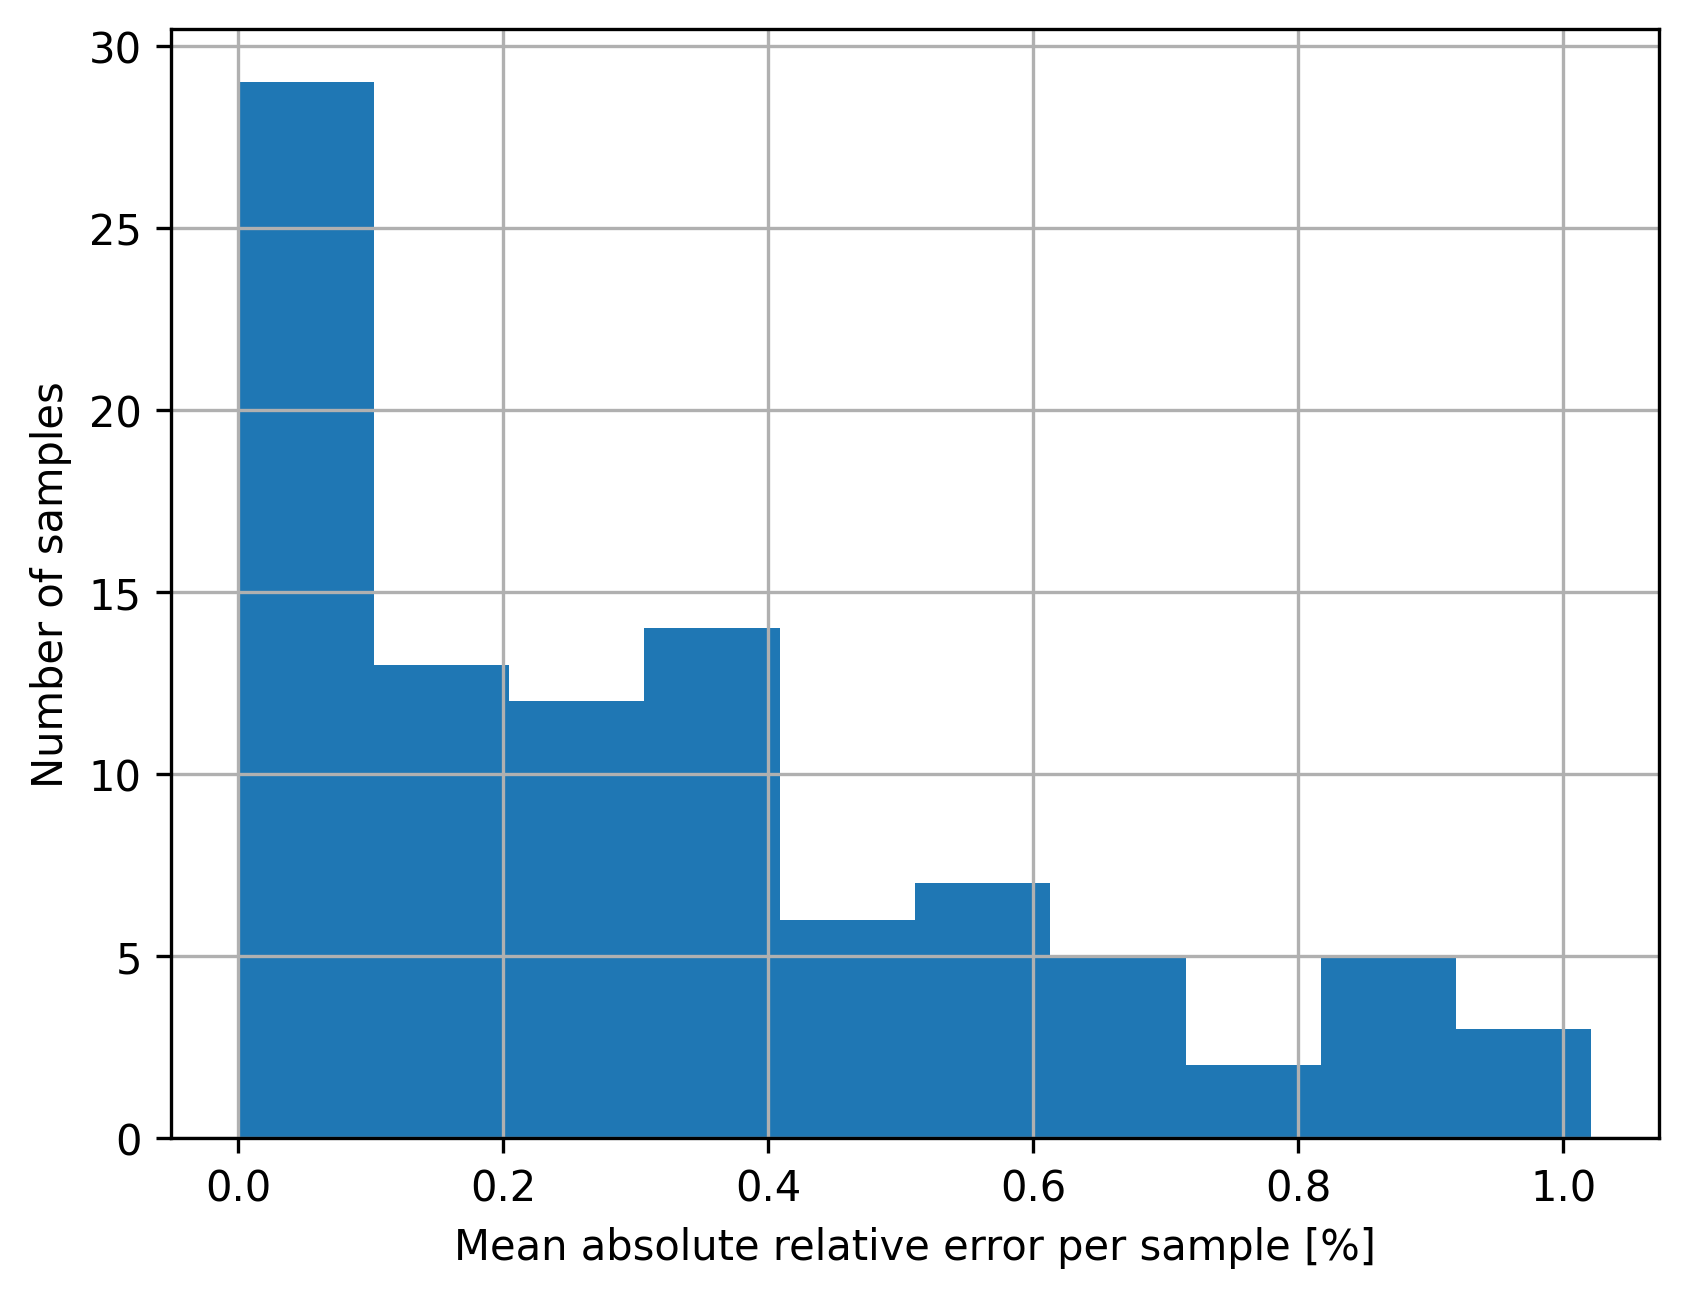

In [16]:
## I assume there is one plate in each adat from now on - if not, each step should be done per plate

RFU_hyb = hyb_norm(RFU, somamers)


# Checking the error of the reverse engineering
(RFU_hyb / RFU_hyb_ref).max().max()
(RFU_hyb / RFU_hyb_ref).min().min() # I got error of up to 3%

#(RFU_hyb / RFU_hyb_ref)

z = RFU_hyb / RFU

x = (RFU_hyb / RFU_hyb_ref)

y = (x <= 0.99) | (x>=1.01)
y = y.apply(sum, axis=1) # TODO: Two samples are not good, the rest are fine, why? Not calibratorts/qc/buffer (66, 13 are not calibrated well - 66 is flagged later not by this step)
# TODO: check if bad samples are flagged
# TODO: start from good plates
# TODO: % vs. error for sample

z = (np.abs(x-1)).apply(np.mean, axis=1) * 100
plt.figure()
z.hist()
plt.xlabel('Mean absolute relative error per sample [%]')
plt.ylabel('Number of samples')
plt.show()

In [19]:
(np.abs(x-1)).apply(np.mean, axis=1) * 100

0     0.000074
1     0.142288
2     0.822935
3     0.055732
4     0.282021
        ...   
91    0.284721
92    0.181451
93    0.324557
94    0.852076
95    0.968779
Length: 96, dtype: float64

(array([1.32600e+03, 6.45400e+03, 6.25700e+03, 2.95000e+02, 6.93446e+05,
        7.59700e+03, 1.12900e+03, 1.26910e+04, 1.60000e+01, 5.00000e+00]),
 array([0.94114556, 0.95472331, 0.96830106, 0.98187881, 0.99545657,
        1.00903432, 1.02261207, 1.03618982, 1.04976757, 1.06334533,
        1.07692308]),
 <BarContainer object of 10 artists>)

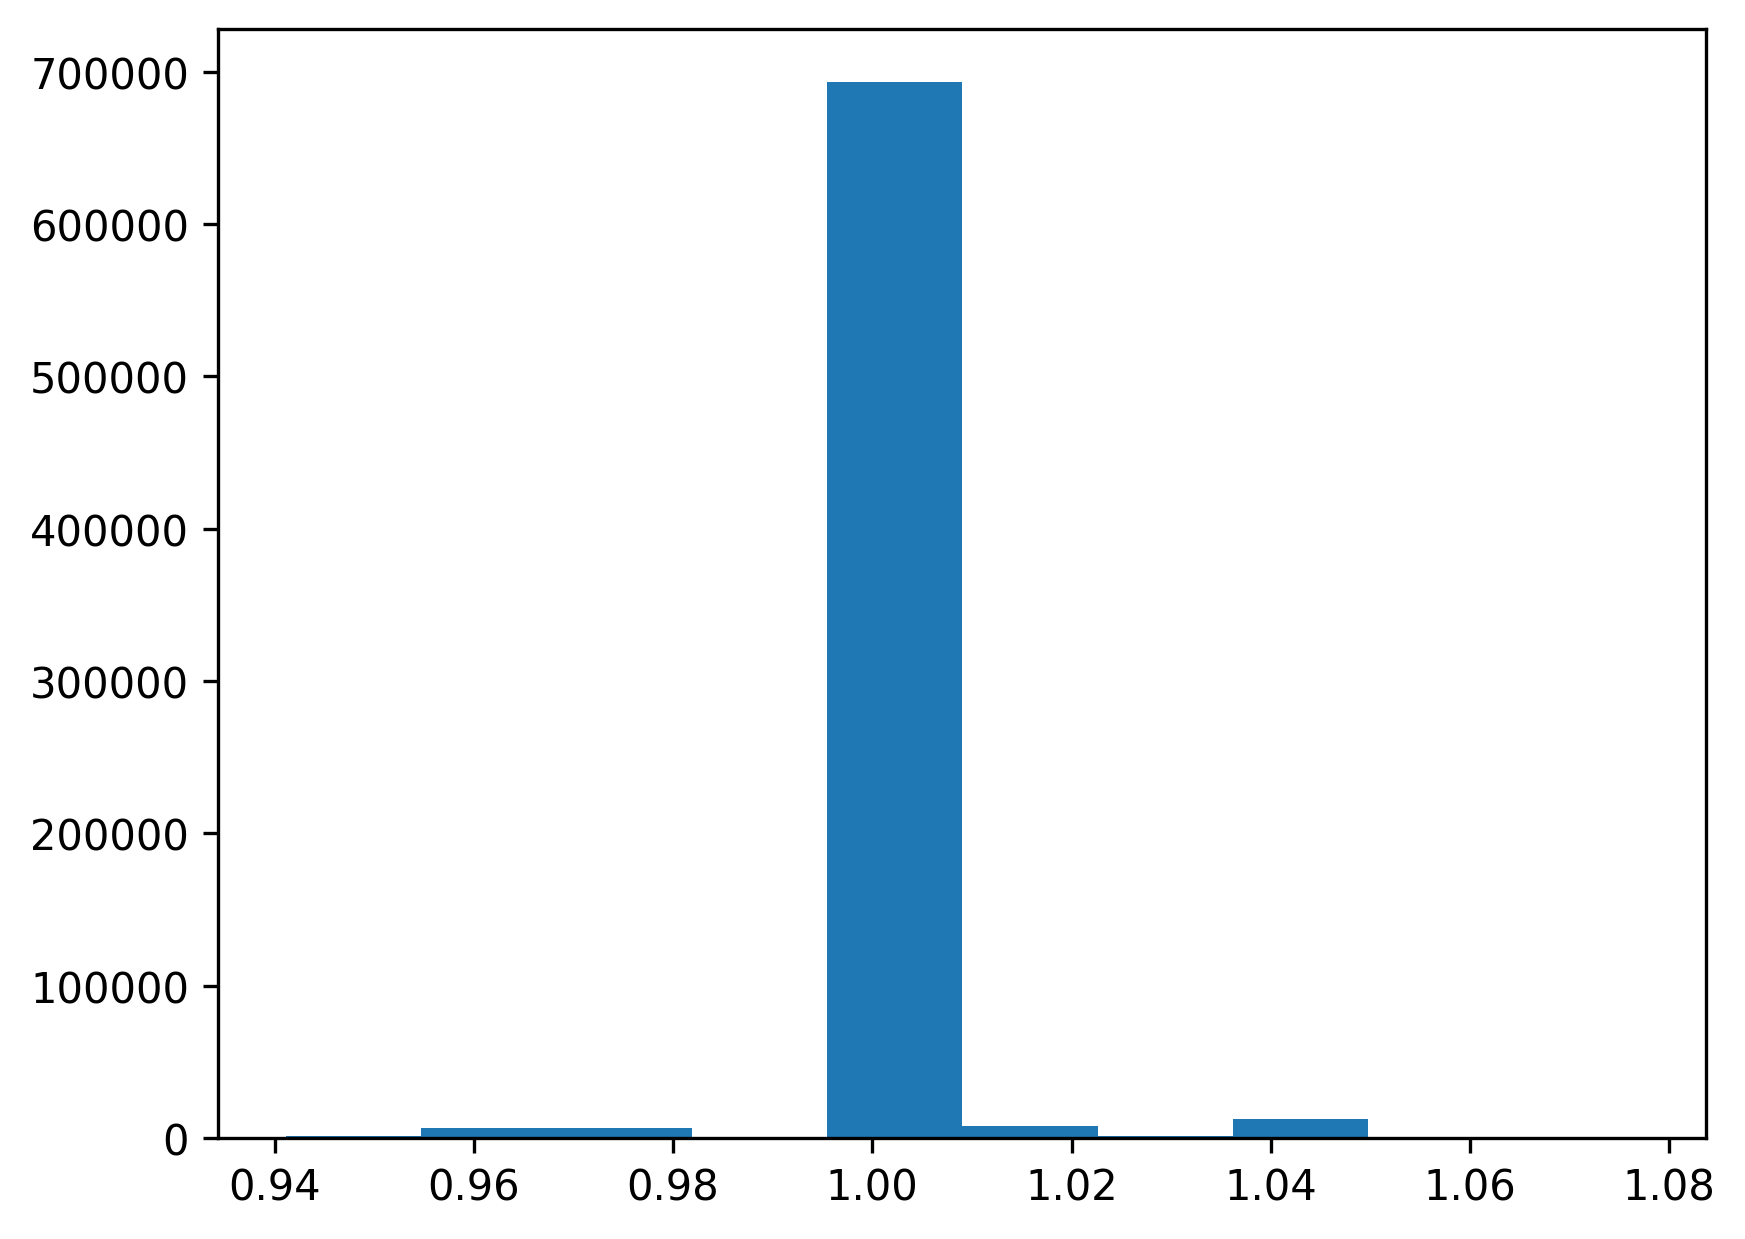

In [20]:
#%% 2 hyb.msnCal reference

RFU_msnCal_ref = pd.read_csv(adat_path.replace('.adat','.hybNorm.medNormInt.adat'), skiprows=46, sep='\t')
RFU_msnCal_ref_meta = RFU_msnCal_ref[RFU_msnCal_ref.columns[:35]] # First time that norm scale columns appear. Changes only calibrators and buffer.
RFU_msnCal_ref = RFU_msnCal_ref[RFU_msnCal_ref.columns[35:]]
RFU_msnCal_ref = RFU_msnCal_ref.rename(columns = {x: seqid_order_list[ind]  for ind, x in enumerate(RFU_msnCal_ref.columns)})
msnCal_ratio = RFU_msnCal_ref / RFU_hyb_ref

plt.hist(msnCal_ratio.values.flatten())

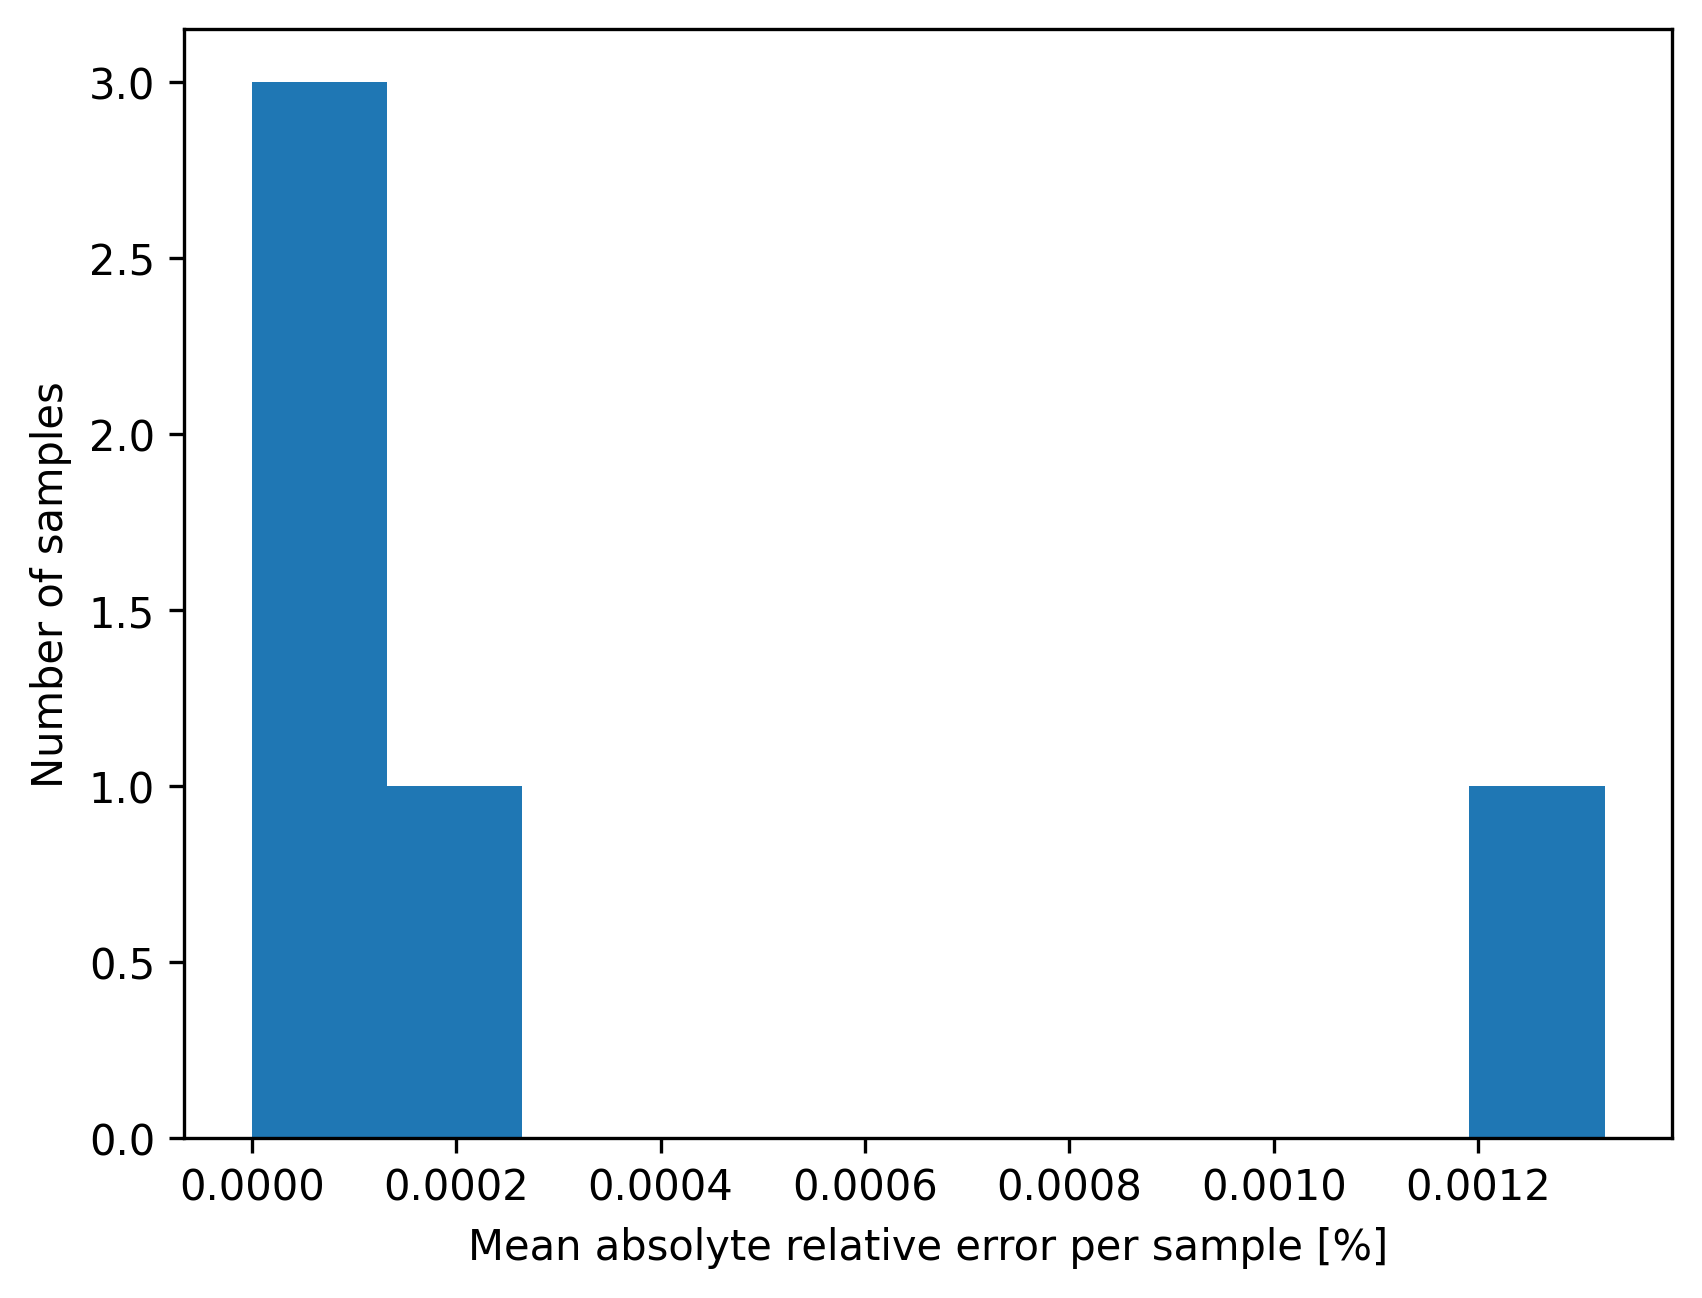

In [21]:
#%% 2 hyb.msnCal without propgating error # Now almost perfect (less than 1% maximal error)

RFU_msnCal = msnCal_norm(RFU_hyb_ref, somamers, sampl, dil_lab)

            
(RFU_msnCal / RFU_msnCal_ref).min().min()
(RFU_msnCal / RFU_msnCal_ref).max().max()

x = (RFU_msnCal / RFU_msnCal_ref)
y = (x < 0.99) | (x>1.01)
y = y.apply(sum, axis=1)

x.max().max()
x.min().min()

z = (np.abs(x.loc[sampl['SampleType'].isin(['Calibrator'])].values-1)).mean(axis=1) * 100
plt.figure()
plt.hist(z)
plt.xlabel('Mean absolyte relative error per sample [%]')
plt.ylabel('Number of samples')
plt.show()


True

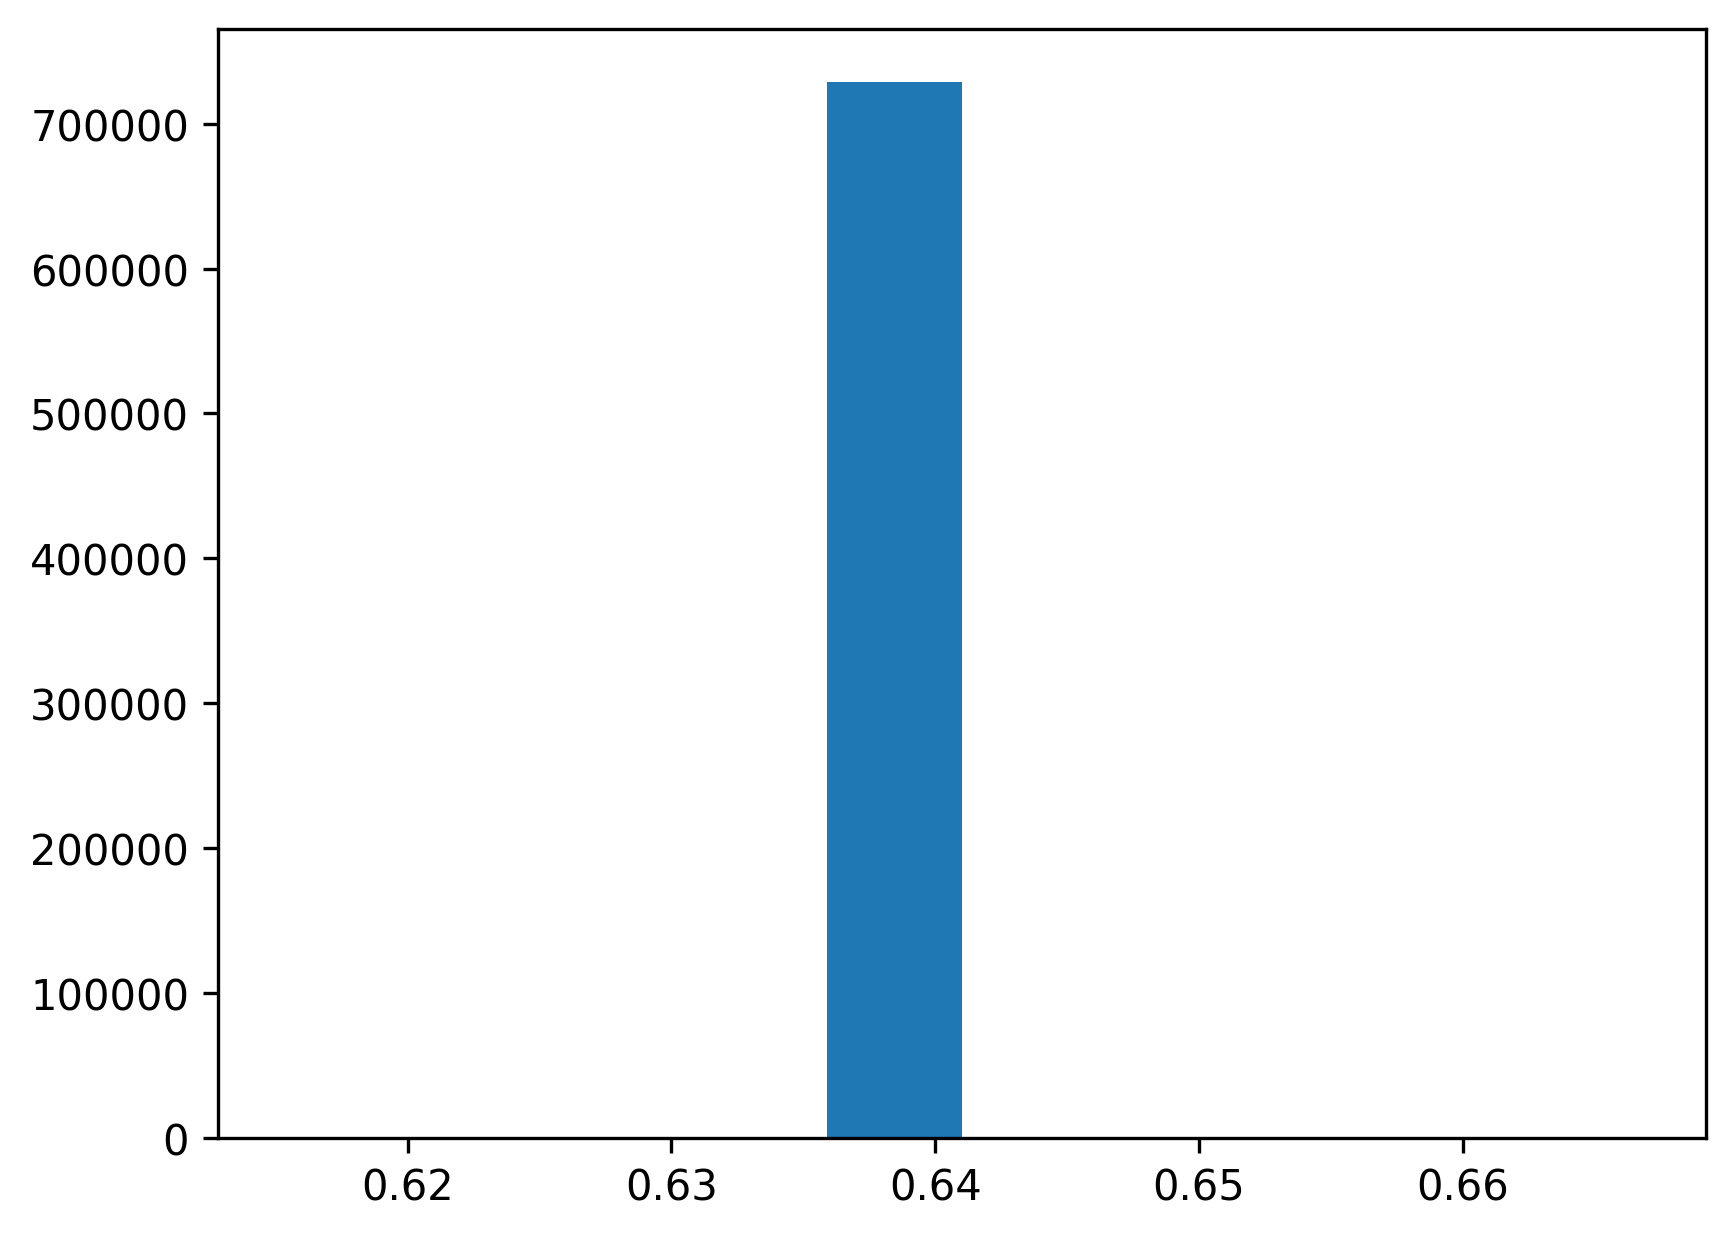

In [22]:
#%% 2 hyb.msnCal with propgating error

RFU_msnCal = msnCal_norm(RFU_hyb, somamers, sampl, dil_lab)

            
(RFU_msnCal / RFU_msnCal_ref).min().min()
(RFU_msnCal / RFU_msnCal_ref).max().max()

#%% 3 hyb.msnCal.ps reference

RFU_ps_ref = pd.read_csv(adat_path.replace('.adat','.hybNorm.medNormInt.plateScale.adat'), skiprows=50, sep='\t')
RFU_ps_ref_meta = RFU_ps_ref[RFU_ps_ref.columns[:35]]
RFU_ps_ref = RFU_ps_ref[RFU_ps_ref.columns[35:]]
RFU_ps_ref = RFU_ps_ref.rename(columns = {x: seqid_order_list[ind]  for ind, x in enumerate(RFU_ps_ref.columns)})
ps_ratio = RFU_ps_ref / RFU_msnCal_ref

plt.hist(ps_ratio.values.flatten())


all(RFU_msnCal_ref_meta['NormScale_20'] == RFU_ps_ref_meta['NormScale_20'])
all(RFU_msnCal_ref_meta['NormScale_0.005'] == RFU_ps_ref_meta['NormScale_0.005'])
all(RFU_msnCal_ref_meta['NormScale_0.5'] == RFU_ps_ref_meta['NormScale_0.5'])


In [38]:
#%% 3 hyb.msnCal.ps with propgating error


RFU_ps = ps_norm(RFU_msnCal, sampl, ps_ref_path)


(RFU_ps / RFU_ps_ref).max().max()
(RFU_ps / RFU_ps_ref).min().min()

x = RFU_ps / RFU_ps_ref

In [ ]:
#%% 3 hyb.msnCal.ps without propgating error - perfect!


RFU_ps = ps_norm(RFU_msnCal_ref, sampl, ps_ref_path)


(RFU_ps / RFU_ps_ref).max().max()
(RFU_ps / RFU_ps_ref).min().min()

x = RFU_ps / RFU_ps_ref

In [ ]:
#%% 4 hyb.msnCal.ps.cal reference

RFU_cal_ref = pd.read_csv(adat_path.replace('.adat','.hybNorm.medNormInt.plateScale.calibrate.adat'), skiprows=58, sep='\t')
RFU_cal_ref_meta = RFU_cal_ref[RFU_cal_ref.columns[:35]]
RFU_cal_ref = RFU_cal_ref[RFU_cal_ref.columns[35:]]
RFU_cal_ref = RFU_cal_ref.rename(columns = {x: seqid_order_list[ind]  for ind, x in enumerate(RFU_cal_ref.columns)})
ps_ratio = RFU_cal_ref / RFU_ps_ref

plt.hist(ps_ratio.values.flatten(), bins=30)

all(RFU_msnCal_ref_meta['NormScale_20'] == RFU_cal_ref_meta['NormScale_20'])
all(RFU_msnCal_ref_meta['NormScale_0.005'] == RFU_cal_ref_meta['NormScale_0.005'])
all(RFU_msnCal_ref_meta['NormScale_0.5'] == RFU_cal_ref_meta['NormScale_0.5'])

In [ ]:
#%% 4 hyb.msnCal.ps.cal with propgating error

RFU_cal = cal_norm(RFU_ps, sampl, ps_ref_path)

(RFU_cal / RFU_cal_ref).max().max()
(RFU_cal / RFU_cal_ref).min().min()

In [ ]:
#%% 4 hyb.msnCal.ps.cal without propgating error - almost perfect. max relative error 0.0025

RFU_cal = cal_norm(RFU_ps_ref, sampl, ps_ref_path)

(RFU_cal / RFU_cal_ref).max().max()
(RFU_cal / RFU_cal_ref).min().min()

z = (np.abs((RFU_cal / RFU_cal_ref)-1)).apply(np.mean, axis=1) * 100
plt.figure()
z.hist()
plt.xlabel('Mean absolyte relative error per sample [%]')
plt.ylabel('Number of samples')
plt.show()

In [ ]:
#%% 5 hyb.msn.Cal.ps.cal.msnAll semi reference
RFU_msnAll_ref1 = pd.read_csv(adat_path.replace('.adat','.hybNorm.medNormInt.plateScale.calibrate.anmlQC.adat'), skiprows=58, sep='\t')
RFU_msnAll_ref1_meta = RFU_msnAll_ref1[RFU_msnAll_ref1.columns[:35]]
RFU_msnAll_ref1 = RFU_msnAll_ref1[RFU_msnAll_ref1.columns[38:]]
RFU_msnAll_ref1 = RFU_msnAll_ref1.rename(columns = {x: seqid_order_list[ind]  for ind, x in enumerate(RFU_msnAll_ref1.columns)})
ps_ratio = RFU_msnAll_ref1 / RFU_cal_ref # This stage changes QC

plt.hist(ps_ratio.values.flatten(), bins=30)

all(RFU_msnAll_ref1_meta.loc[RFU_msnAll_ref1_meta['SampleType']!='QC', 'NormScale_20'] == RFU_cal_ref_meta.loc[RFU_cal_ref_meta['SampleType']!='QC', 'NormScale_20'])
all(RFU_msnAll_ref1_meta['NormScale_0.005'] == RFU_cal_ref_meta['NormScale_0.005'])
all(RFU_msnAll_ref1_meta['NormScale_0.5'] == RFU_cal_ref_meta['NormScale_0.5'])



RFU_msnAll_ref2 = pd.read_csv(adat_path.replace('.adat','.hybNorm.medNormInt.plateScale.calibrate.anmlQC.qcCheck.adat'), skiprows=63, sep='\t') # no change
RFU_msnAll_ref2_meta = RFU_msnAll_ref2[RFU_msnAll_ref2.columns[:35]]
RFU_msnAll_ref2 = RFU_msnAll_ref2[RFU_msnAll_ref2.columns[38:]]
RFU_msnAll_ref2 = RFU_msnAll_ref2.rename(columns = {x: seqid_order_list[ind]  for ind, x in enumerate(RFU_msnAll_ref2.columns)})
ps_ratio = RFU_msnAll_ref2 / RFU_msnAll_ref1

plt.hist(ps_ratio.values.flatten(), bins=30)

all(RFU_msnAll_ref1_meta['NormScale_20'] == RFU_msnAll_ref2_meta['NormScale_20'])
all(RFU_msnAll_ref1_meta['NormScale_0.005'] == RFU_msnAll_ref2_meta['NormScale_0.005']) # No change here
all(RFU_msnAll_ref1_meta['NormScale_0.5'] == RFU_msnAll_ref2_meta['NormScale_0.5'])


RFU_msnAll_ref3 = pd.read_csv(adat_path.replace('.adat','.hybNorm.medNormInt.plateScale.calibrate.anmlQC.qcCheck.anmlSMP.adat'), skiprows=63, sep='\t') # no change
RFU_msnAll_ref3_meta = RFU_msnAll_ref3[RFU_msnAll_ref3.columns[:37]]
RFU_msnAll_ref3 = RFU_msnAll_ref3[RFU_msnAll_ref3.columns[38:]]
RFU_msnAll_ref3 = RFU_msnAll_ref3.rename(columns = {x: seqid_order_list[ind]  for ind, x in enumerate(RFU_msnAll_ref3.columns)})
ps_ratio = RFU_msnAll_ref3 / RFU_msnAll_ref2 # This stage changes samples only

plt.hist(ps_ratio.values.flatten(), bins=30)


all(RFU_msnAll_ref3_meta.loc[RFU_msnAll_ref1_meta['SampleType']=='QC', 'NormScale_20'] == RFU_msnAll_ref2_meta.loc[RFU_msnAll_ref1_meta['SampleType']=='QC', 'NormScale_20']) # Does not change QC
all(RFU_msnAll_ref3_meta.loc[RFU_msnAll_ref1_meta['SampleType']=='Buffer', 'NormScale_20'] == RFU_msnAll_ref2_meta.loc[RFU_msnAll_ref1_meta['SampleType']=='Buffer', 'NormScale_20']) # Does not change Calibrator or buffer

all(RFU_msnAll_ref3_meta['NormScale_0.005'] == RFU_msnAll_ref2_meta['NormScale_0.005']) # Changes only samples
all(RFU_msnAll_ref3_meta['NormScale_0.5'] == RFU_msnAll_ref2_meta['NormScale_0.5'])


In [ ]:
#%% 5 hyb.msn.Cal.ps.cal.msnAll

RFU_msnAll = msnAll_norm(RFU_cal, somamers, sampl, dil_lab)

(RFU_msnAll / RFU_msnAll_ref3).max().max()
(RFU_msnAll / RFU_msnAll_ref3).min().min()

In [ ]:
#%% Trying to replicate ANML
# df_anml = pd.read_csv('../SD4.1ReV_Plasma_ANML.txt', sep='\t')
# ref_med_col = 'RefMedian' # 'Reference'
# # df_anml = pd.read_csv('SD4.1ReV_Plasma_QC_ANML_200170.txt', sep='\t')
# # df_anml = pd.merge(left=pd.read_csv('SD4.1ReV_Plasma_ANML.txt', sep='\t'), right=df_anml, on='SeqId', how='inner')
# df_anml = df_anml.set_index('SeqId')
# num_anml_iterations = 3

# dil_lab= ("20", "0", "0_005", "0_5", )
# RFU_anmlCal = RFU_cal_ref.copy() #RFU_cal.copy()


# res = {}
# for sampl_type in ['Sample']: # Only calibrators according to the paper
#     sel2 = sampl['SampleType'] == sampl_type
#     indx_sampl_list = sampl.index[sel2]
#     for ind, indx_sampl in enumerate(indx_sampl_list):
#         if ind%10 == 0:
#             print(ind)
#         res[indx_sampl] = {}
#         for dil in dil_lab:
#             for ind in range(num_anml_iterations):
#                 somamers_dil = somamers[somamers['Dilution'] == dil].index
#                 somamers_dil_in_range = (RFU_anmlCal.loc[indx_sampl, somamers_dil] >= (df_anml.loc[somamers_dil, ref_med_col] - 2*df_anml.loc[somamers_dil, 'RefSD'])) & (RFU_anmlCal.loc[indx_sampl, somamers_dil] <= (df_anml.loc[somamers_dil, ref_med_col] + 2*df_anml.loc[somamers_dil, 'RefSD'])) 
#                 somamers_dil_in_range = somamers_dil_in_range.loc[somamers_dil_in_range].index
#                 # RFU_msnCal.loc[indx_sampl, somamers_tmp].median()
#                 rgd_ialpha = RFU_anmlCal.loc[indx_sampl, somamers_dil_in_range] / df_anml.loc[somamers_dil_in_range, ref_med_col]
#                 SFgd = 1 / rgd_ialpha.mean()#.median()
#                 RFU_anmlCal.loc[indx_sampl, somamers_dil] = RFU_anmlCal.loc[indx_sampl, somamers_dil] * SFgd
#                 RFU_anmlCal.loc[indx_sampl, somamers_dil] = RFU_anmlCal.loc[indx_sampl, somamers_dil].apply(lambda x: round(x,1))
#                 if ind == 0:
#                     res[indx_sampl][dil] = (len(somamers_dil_in_range)/len(somamers_dil), SFgd)
#                 else:
#                     res[indx_sampl][dil] = (len(somamers_dil_in_range)/len(somamers_dil), res[indx_sampl][dil][1]*SFgd)
#             if res[indx_sampl][dil][1] < 0.3 or res[indx_sampl][dil][1] > 2.5 or res[indx_sampl][dil][0] < 0.3:
#                 RFU_anmlCal.loc[indx_sampl, somamers_dil] = RFU_cal.loc[indx_sampl, somamers_dil]


In [ ]:
RFU_anmlCal, res = ANML_norm(RFU_cal_ref=RFU_cal_ref, somamers=somamers, sampl=sampl,
                             num_anml_iterations=200, dil_lab=("0", "0_005", "0_5", "20"),
                             ref_files_path='../')

(RFU_anmlCal / RFU_msnAll_ref3).max().max()
(RFU_anmlCal / RFU_msnAll_ref3).min().min()
t = (RFU_anmlCal / RFU_cal_ref)

x = RFU_anmlCal / RFU_msnAll_ref3

x.max().max()
x.min().min()
(x.iloc[:,0] < 1.05).sum() / len(x)



x = np.abs(x - 1)
# y = (x < 0.99) | (x>1.01) #(x < 0.99) | (x>1.01)
y = x>0.01
y = y.apply(sum, axis=1) # Works perfect on Calibrator and Buffer, 
z = x.apply(sum, axis=1)

by_seqid = pd.merge(left=pd.DataFrame(x.mean(), columns=['Error']), right=somamers, left_index=True, right_index=True)
by_seqid.groupby('Dilution')['Error'].mean()

z = (np.abs(( RFU_anmlCal / RFU_msnAll_ref3)-1)).apply(np.mean, axis=1) * 100
plt.figure()
z.hist()
plt.xlabel('Mean absolyte relative error per sample [%]')
plt.ylabel('Number of samples')
plt.show()



In [ ]:
#%% Trying to replicate ANML with MAD
# df_anml = pd.read_csv('../SD4.1ReV_Plasma_ANML.txt', sep='\t')
ref_med_col = 'RefLog10Median' # 'RefMedian' # 'Reference'
ref_sd_col = 'RefLog10MAD' #
# factor = 1.4826*3 #2 
factor_dict = {'20': 2, '0': 2, '0_005': 2, '0_5': 2,} #{'20': 1.4826*3, '0': 1.4826*1.5, '0_005': 1.4826*2, '0_5': 1.4826*2,}
df_anml = pd.read_csv('../SD4.1ReV_Plasma_QC_ANML_200170.txt', sep='\t')
df_anml = df_anml.rename(columns={'Reference': 'RefMedianQC'})
df_anml['RefLog10MedianQC'] = np.log10(df_anml['RefMedianQC'])
df_anml = pd.merge(left=pd.read_csv('../SD4.1ReV_Plasma_ANML.txt', sep='\t'), right=df_anml, on='SeqId', how='inner')
df_anml['RefSDLog10'] = np.log10(df_anml['RefSD'])
df_anml = df_anml.set_index('SeqId')
num_anml_iterations = 10#200
min_fraction_to_use = 0.4
log_multiplier = False

# different factor per dilution (higher for 20 than the other dilutions)

dil_lab= ("20", "0", "0_005", "0_5", )
RFU_anmlCal = RFU_cal_ref.copy() #RFU_cal.copy()
RFU_anmlCal_log = RFU_anmlCal.apply(np.log10).copy()

res = {}
for sampl_type in ['QC', 'Sample']: # Only calibrators according to the paper
    if sampl_type == 'Sample':
        ref_med_col_sampl = 'RefLog10Median'
        ref_sd_col_sampl = 'RefLog10MAD'
    elif sampl_type == 'QC':
        ref_med_col_sampl ='RefLog10MedianQC'
        ref_sd_col_sampl = 'RefSDLog10'
    sel2 = sampl['SampleType'] == sampl_type
    indx_sampl_list = sampl.index[sel2]
    for ind, indx_sampl in enumerate(indx_sampl_list):
        if ind%10 == 0:
            print(ind)
        res[indx_sampl] = {}
        for dil in dil_lab:
            factor = factor_dict[dil]
            # if sampl_type == 'QC':
            #     factor = 2
            for ind2 in range(num_anml_iterations):
                somamers_dil = somamers[somamers['Dilution'] == dil].index
                somamers_dil_in_range = (RFU_anmlCal_log.loc[indx_sampl, somamers_dil] >= (df_anml.loc[somamers_dil, ref_med_col_sampl] - factor*df_anml.loc[somamers_dil, ref_sd_col_sampl])) & (RFU_anmlCal_log.loc[indx_sampl, somamers_dil] <= (df_anml.loc[somamers_dil, ref_med_col_sampl] + factor*df_anml.loc[somamers_dil, ref_sd_col_sampl])) 
                somamers_dil_in_range = somamers_dil_in_range.loc[somamers_dil_in_range].index
                fraction_in_range = len(somamers_dil_in_range)/len(somamers_dil)
                # if fraction_in_range < min_fraction_to_use:
                #     print('in condition')
                #     target_value = df_anml.loc[somamers_dil, ref_med_col_sampl]
                #     data_diff = np.abs(RFU_anmlCal_log.loc[indx_sampl, somamers_dil] - target_value)
                #     sorted_indices = np.argsort(data_diff)
                #     n = int(len(RFU_anmlCal_log.loc[indx_sampl, somamers_dil]) * min_fraction_to_use)
                #     somamers_dil_in_range = sorted_indices.sort_values()[:n].index
                    
                # RFU_msnCal.loc[indx_sampl, somamers_tmp].median()
                if log_multiplier:
                    rgd_ialpha = RFU_anmlCal_log.loc[indx_sampl, somamers_dil_in_range] - (df_anml.loc[somamers_dil_in_range, ref_med_col_sampl])
                    inv_log_SFgd = round(rgd_ialpha.mean(), 6)
                    SFgd = round(1 / 10 ** inv_log_SFgd, 6)
                else:
                    rgd_ialpha = RFU_anmlCal.loc[indx_sampl, somamers_dil_in_range] / (10**df_anml.loc[somamers_dil_in_range, ref_med_col_sampl])
                    SFgd = 1 / rgd_ialpha.median()
                RFU_anmlCal.loc[indx_sampl, somamers_dil] = RFU_anmlCal.loc[indx_sampl, somamers_dil] * SFgd
                RFU_anmlCal.loc[indx_sampl, somamers_dil] = RFU_anmlCal.loc[indx_sampl, somamers_dil]#.apply(lambda x: round(x,1))
                RFU_anmlCal_log.loc[indx_sampl, somamers_dil] = RFU_anmlCal.loc[indx_sampl, somamers_dil].apply(np.log10)
                if ind2 == 0:
                    res[indx_sampl][dil] = (fraction_in_range, SFgd)
                else:
                    iter_res = (fraction_in_range, res[indx_sampl][dil][1]*SFgd)
                    if iter_res == res[indx_sampl][dil]:
                        # print(f"Iteration {ind} didn't change result.")
                        break
                    res[indx_sampl][dil] = (fraction_in_range, res[indx_sampl][dil][1]*SFgd)
                if res[indx_sampl][dil][0] >= 1:
                    # print(f'Exited after {ind} iterations.')
                    break
                # print(res[indx_sampl][dil][1], SFgd)
            # if res[indx_sampl][dil][1] < 0.3 or res[indx_sampl][dil][1] > 2.5 or res[indx_sampl][dil][0] < 0.3:
            #     RFU_anmlCal.loc[indx_sampl, somamers_dil] = RFU_cal.loc[indx_sampl, somamers_dil]
            #     RFU_anmlCal_log.loc[indx_sampl, somamers_dil] = RFU_anmlCal.loc[indx_sampl, somamers_dil].apply(np.log10)



(RFU_anmlCal / RFU_msnAll_ref3).max().max()
(RFU_anmlCal / RFU_msnAll_ref3).min().min()
t = (RFU_anmlCal / RFU_cal_ref)

x = np.round(RFU_anmlCal, 1) / RFU_msnAll_ref3

x.max().max()
x.min().min()
(x.iloc[:,0] < 1.05).sum() / len(x)

x = np.round(RFU_anmlCal, 1) / RFU_msnAll_ref3

# x = (RFU_anmlCal / RFU_msnAll_ref3)
plt.figure()
plt.hist(x.values.flatten()-1, bins=30)
plt.show()

plt.figure()
plt.hist(x.loc[~sampl['SampleType'].isin(['QC', 'Buffer', 'Calibrator'])].values.flatten()-1, bins=30)
plt.show()

np.mean(x.values.flatten()-1)
np.std(x.values.flatten()-1)

np.mean(x.loc[~sampl['SampleType'].isin(['QC', 'Buffer', 'Calibrator'])].values.flatten()-1)
np.std(x.loc[~sampl['SampleType'].isin(['QC', 'Buffer', 'Calibrator'])].values.flatten()-1)


x = np.abs(x - 1)
# y = (x < 0.99) | (x>1.01) #(x < 0.99) | (x>1.01)
y = x>0.01
y = y.apply(sum, axis=1) # Works perfect on Calibrator and Buffer, 
z = x.apply(sum, axis=1)

by_seqid = pd.merge(left=pd.DataFrame(x.mean(), columns=['Error']), right=somamers, left_index=True, right_index=True)
by_seqid.groupby('Dilution')['Error'].mean()


by_seqid = pd.merge(left=pd.DataFrame(x.loc[~sampl['SampleType'].isin(['QC', 'Calibrator', 'Buffer'])].mean(), columns=['Error']), right=somamers, left_index=True, right_index=True)
by_seqid.groupby('Dilution')['Error'].mean()

by_seqid = pd.merge(left=pd.DataFrame(x.loc[sampl['SampleType'].isin(['QC'])].mean(), columns=['Error']), right=somamers, left_index=True, right_index=True)
by_seqid.groupby('Dilution')['Error'].mean()


by_seqid = pd.merge(left=pd.DataFrame(x.loc[~sampl['SampleType'].isin(['QC'])].mean(), columns=['Error']), right=somamers, left_index=True, right_index=True)
by_seqid.groupby('Dilution')['Error'].mean()

# by_seqid = pd.merge(left=pd.DataFrame(x.loc[~sampl['SampleType'].isin(['QC'])].mean(), columns=['Error']), right=somamers, left_index=True, right_index=True)
# by_seqid.groupby('Dilution')['Error'].mean()

# Calibrator and buffer are perfect because unchanged

# Flagged samples [3, 8, 12, 19, 51, 55, 56, 60, 66, 68, 86, 88, 91, 95]




In [ ]:
 #%% Analyzing ANML results



# Flatten the dictionary into a DataFrame
flattened_data = []
for outer_key, inner_dict in res.items():
    row = {'Index': outer_key}
    for inner_key, value in inner_dict.items():
        row[inner_key] = value
    flattened_data.append(row)

df = pd.DataFrame(flattened_data)
df.set_index('Index', inplace=True)

# Splitting the tuples into separate columns
new_columns = {}
for col in df.columns:
    df[[f"{col}_Fraction", f"{col}_Scale"]] = pd.DataFrame(df[col].tolist(), index=df.index)
    new_columns[col] = [f"{col}_Fraction", f"{col}_Scale"]

# Drop the original columns containing tuples
df.drop(columns=list(new_columns.keys()), inplace=True)

df_inspect = pd.merge(left=df, right=RFU_msnAll_ref3_meta,
                      how='left', left_index=True, right_index=True)

for dil in ['20', '0.5', '0.005']:
    plt.figure()
    plt.plot(df_inspect[f'NormScale_{dil}'], df_inspect[f'{dil.replace(".", "_")}_Scale'], 'x')
    plt.plot([df_inspect[f'NormScale_{dil}'].min(), df_inspect[f'NormScale_{dil}'].max()], [df_inspect[f'NormScale_{dil}'].min(), df_inspect[f'NormScale_{dil}'].max()], color='red', linestyle='--', label="Unity Line")
    plt.xlabel(f'SL NormScale_{dil}')
    plt.ylabel(f'OH NormScale_{dil}')
    plt.show()
    
for dil in ['0_005', '20', '0_5']:
    plt.figure()
    plt.plot(df_inspect[f'ANMLFractionUsed_{dil}'], df_inspect[f'{dil}_Fraction'], 'x')
    plt.plot([df_inspect[f'ANMLFractionUsed_{dil.replace(".", "_")}'].min(), df_inspect[f'ANMLFractionUsed_{dil.replace(".", "_")}'].max()], [df_inspect[f'ANMLFractionUsed_{dil.replace(".", "_")}'].min(), df_inspect[f'ANMLFractionUsed_{dil.replace(".", "_")}'].max()], color='red', linestyle='--', label="Unity Line")
    plt.xlabel(f'SL ANMLFractionUsed_{dil}')
    plt.ylabel(f'OH ANMLFractionUsed_{dil}')
    plt.show()

# Check if QC step changes only QC

#%%
sampl['SampleType'].value_counts()
sampl[sampl['SampleType'] == 'Calibrator']
sampl[sampl['SampleType'] == 'Buffer']
sampl[sampl['SampleType'] == 'QC']

sampl[sampl['SampleType'].isin(['Calibrator', 'Buffer'])]
#%%

import json

# Path to your JSON file
file_path = "../241027 Flag Pass check/014/OH2024_014.json"

# Open and load the JSON file into a dictionary
with open(file_path, "r") as json_file:
    data = json.load(json_file)
    
#%%
